Learn iterator for multiphase elastic problems using PAC-FEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ThermalDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

Test PAC-FEANet for thermal problems

In [4]:
model_name = 'thermal_type2_2d_33x33'
training_set = ThermalDataSet('data/thermal/thermal_type2_2d_33x33.h5', device)
model_dir = 'model/learn_iterator/thermal_type2'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 5
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

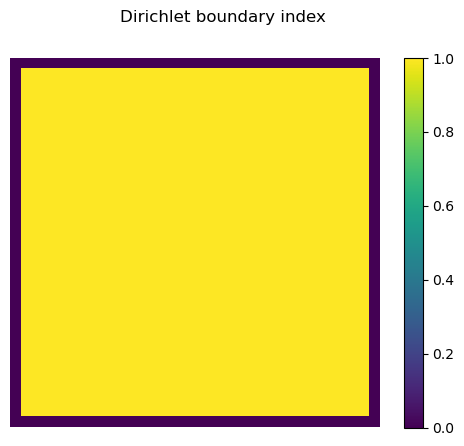

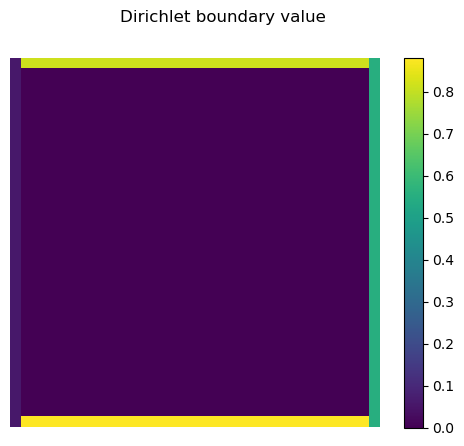

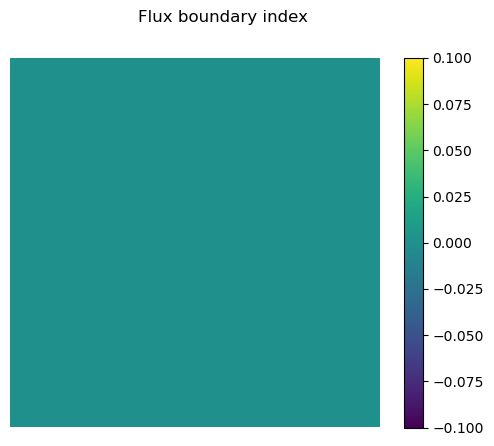

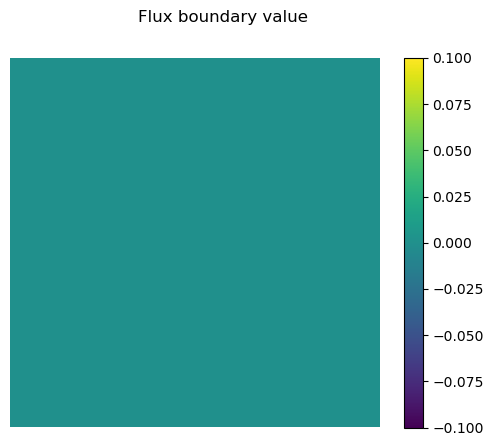

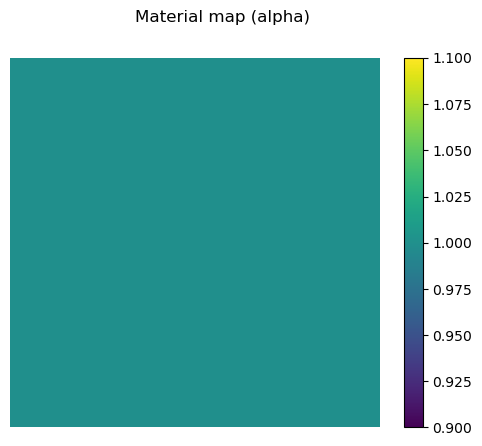

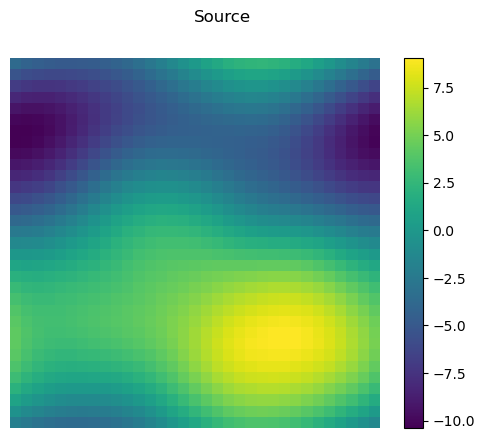

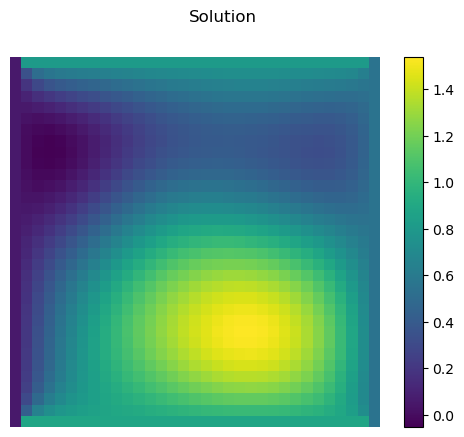

In [5]:
''''''
plot.plot_thermalfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_train[k], ftitle='Flux boundary index')
plot.plot_thermalfield(neumann_value_train[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_train[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(f_train[k], ftitle='Source')
plot.plot_thermalfield(u_train[k], ftitle='Solution')


In [6]:
domain_size = 2
n_elem = 2**5
ku, kf = 1, 1
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='thermal', dev=device_predict)

In [7]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 6.082901048423751
1 3.4453128412543865
2 2.5300058783706323
3 2.0507644263554745
4 1.7511834352912004
5 1.5440388152676565
6 1.3910833596253587
7 1.2727716600338117
8 1.1780271005227672
9 1.1000835676635528
10 1.0345652547172839
11 0.9785119810702106
12 0.9298468920657841
13 0.8870682584823787
14 0.8490622832259617
15 0.8149847711177028
16 0.7841837509341831
17 0.7561473811889985
18 0.7304679785321097
19 0.7068166206572826
20 0.6849248588282384
21 0.6645713166934472
22 0.645571713954174
23 0.6277713333236848
24 0.6110392585945043
25 0.5952639153302289
26 0.580349582398514
27 0.5662136359063097
28 0.5527843518589031
29 0.5399991394553587
30 0.5278031094653277
31 0.5161479056391621
32 0.5049907442883357
33 0.49429361987431286
34 0.4840226439274632
35 0.4741474917664763
36 0.46464093692599756
37 0.4554784573703085
38 0.4466379007939997
39 0.4380991988199226
40 0.4298441218714281
41 0.42185606804706727
42 0.4141198805565043
43 0.406621689257927
44 0.39934877262421103
45 0.392289437099136

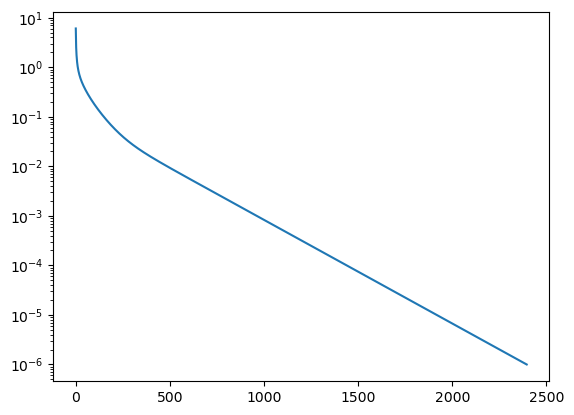

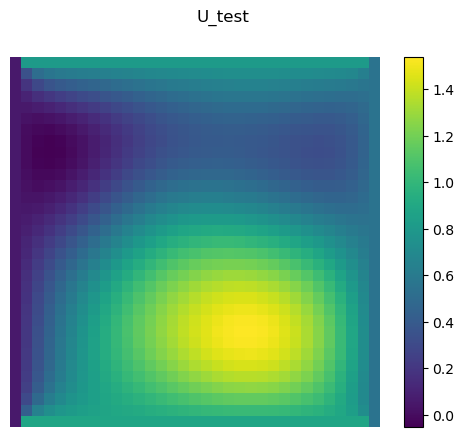

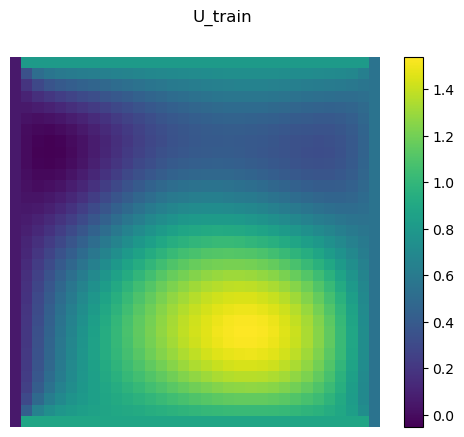

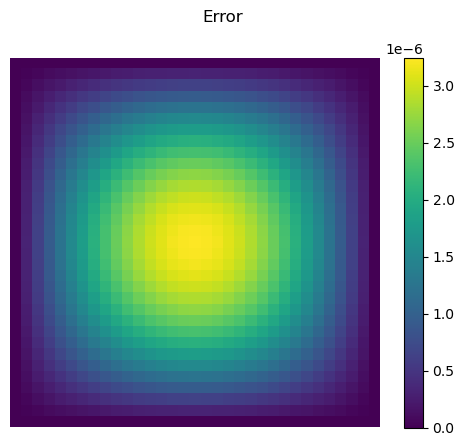

In [8]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_thermalfield(u_test[0], "U_test")
plot.plot_thermalfield(solution_test[0], "U_train")
plot.plot_thermalfield(u_test[0]-solution_test[0], 'Error')

In [9]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''
        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [10]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=3, mode=mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

Step-0 loss: 2488.3618527843946
Step-50 loss: 1241.3188214589877
Step-100 loss: 1226.380884066609
Step-150 loss: 1262.6353379124082
Step-200 loss: 1256.5204143015967
Step-250 loss: 1271.4247037363198
Step-300 loss: 1248.7954207882997
Step-350 loss: 1256.7457769556172
Step-400 loss: 1246.677999321854
Step-450 loss: 1242.7302731633151
Step-500 loss: 1238.0080380657332
Step-550 loss: 1238.350874535477
Step-600 loss: 1221.8318166147776
Step-650 loss: 1233.3526809810687
Step-700 loss: 1234.4819266093546
Step-750 loss: 1253.0347693454182
Step-800 loss: 1240.8933485644397
Step-850 loss: 1243.9102134536558
Step-900 loss: 1250.7695440566433
Step-950 loss: 1229.6619164520857
Average loss:  tensor(1238.2063) , STD:  tensor(13.7033)


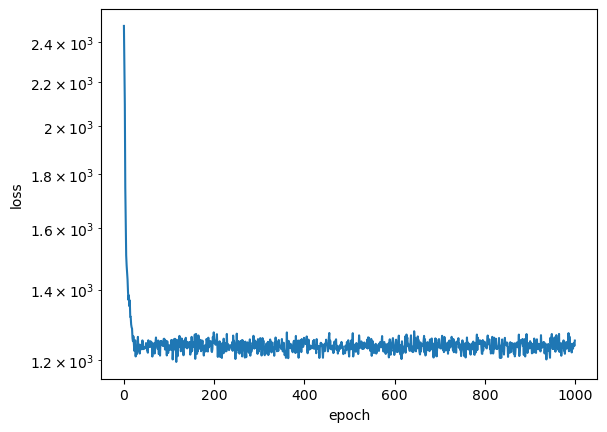

In [11]:
my_iterator = PsiIterator(device, batch_size=bs)
''''''
loss_train = my_iterator.Train(training_set)

plt.plot(loss_train)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))


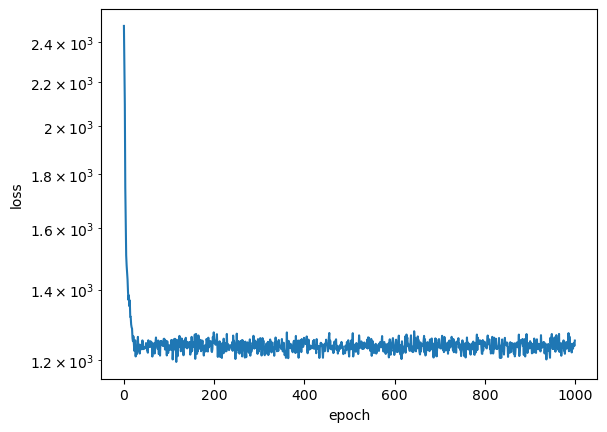

In [12]:
# import the learned model and loss train
my_net = PsiNet(mode='thermal').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, psi_net=my_net, grid=grid, batch_size=1)

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 6.082901048423751
1 1.7640114870251522
2 0.8035467981534595
3 0.5301295065676801
4 0.4154361118027842
5 0.34422237943296136
6 0.29151190853480324
7 0.24996914070942725
8 0.21628852010186767
9 0.18850321149495
10 0.16528445424924781
11 0.14568134823117865
12 0.12899127212134243
13 0.11468303748716237
14 0.10234711952390466
15 0.09166200969692773
16 0.08237095001029902
17 0.07426561772815256
18 0.0671745556456995
19 0.060954878140469605
20 0.05548625505584937
21 0.05066648898695749
22 0.04640821348783013
23 0.04263638436921235
24 0.039286335667253765
25 0.03630224065857645
26 0.033635866261761876
27 0.031245542842562236
28 0.029095295193518594
29 0.027154097204777634
30 0.025395224459014404
31 0.023795687048570553
32 0.022335730326614935
33 0.02099839481651463
34 0.01976912868950514
35 0.018635447519611215
36 0.017586636765262755
37 0.016613492844858142
38 0.01570809892849493
39 0.014863631760319023
40 0.014074196011660652
41 0.013334682870185022
42 0.012640649801430242
43 0.0119882186

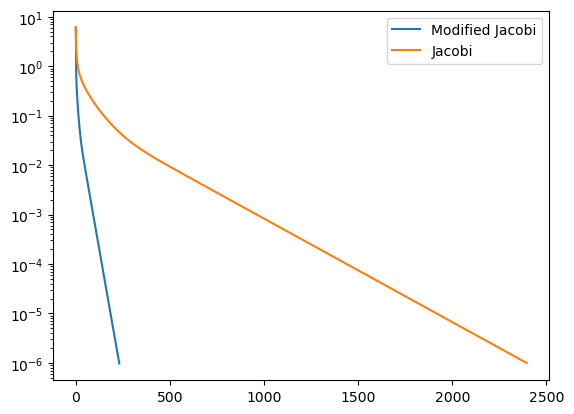

In [13]:
EPS = 1e-6
n_new = 0
u_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
res_arr_new = [res]
print(n_new, res)
while (abs(res) > EPS):
    u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    res_arr_new.append(res)
    n_new += 1
    print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()

In [14]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        # x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        # x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        # x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        # x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        # x_C[:,:,0,0] = x[:,:,0,0]
        # x_C[:,:,0,-1] = x[:,:,0,-1]
        # x_C[:,:,-1,0] = x[:,:,-1,0]
        # x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [15]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.iterators = self.IteratorDict() # dictionary of iterators

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=prob_size)
        return iterators        
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel = torch.ones((1,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel, stride=2)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel, stride=2)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel, stride=2)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel, stride=2)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel, stride=2) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel, stride=2)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [16]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

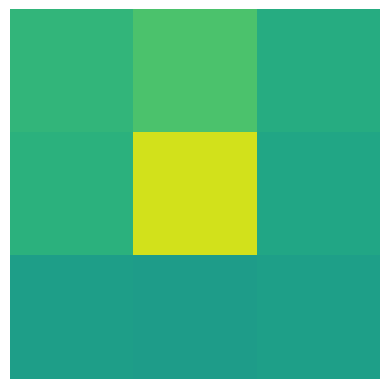

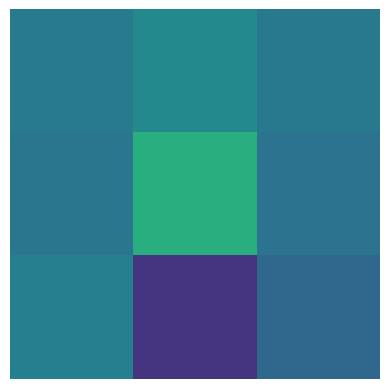

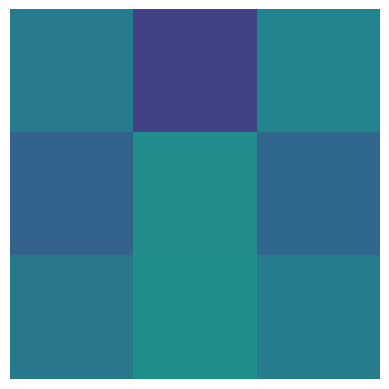

In [17]:
# plot the kernels
mlist = list(my_net.cpu().parameters())
heatmap2d(mlist[0].view(3,3).detach().numpy(),fname='results/kernel1.jpg', cbar=False)
heatmap2d(mlist[1].view(3,3).detach().numpy(),fname='results/kernel2.jpg', cbar=False)
heatmap2d(mlist[2].view(3,3).detach().numpy(),fname='results/kernel3.jpg', cbar=False)

In [18]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [19]:
kernel1 = conv_op(mlist[0].view(3,3).detach(), mlist[1].view(3,3).detach(), max_size=5)
kernel2 = conv_op(kernel1, mlist[2].view(3,3).detach(), max_size=7)
kernel2 = kernel2.reshape(1,1,7,7)

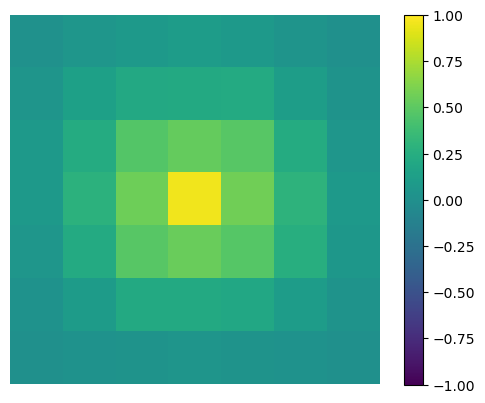

In [20]:
heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [21]:
test_set = ThermalDataSet('data/thermal/thermal_type2_2d_65x65.h5', device)

bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=1
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [22]:
EPS = 1e-6
n = 2**6
h = 2./n
n_mg_jac = 0
mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, iterator='jac') # create a multigrid model
u_mg = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
mg_jac.ProblemDictArray(u_mg,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
u_mg = mg_jac.p_arr[0]['u0']
residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item()
err_occured = False
res_arr_mgjac = [res]
print(n_mg_jac, res)

start = time.time()
while (abs(res) > EPS):
    u_mg = mg_jac.Step(u_mg)
    #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    res_arr_mgjac.append(res)
    n_mg_jac += 1
    print(n_mg_jac, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 11.514018511755037
1 2.533377147920617
2 0.6123741245627957
3 0.14962637378467616
4 0.03682336601813031
5 0.009116235085497998
6 0.0022684728090472572
7 0.0005670545762813637
8 0.00014232998795370405
9 3.585867468216746e-05
10 9.065475533214784e-06
11 2.299195657752968e-06
12 5.848622233740821e-07
Solution converges after 12 Jacobi multigrid iterations in 0.1983022689819336 seconds.


In [23]:
EPS = 1e-6
n = 2**6
h = 2./n
n_mg_jac = 0
mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, iterator='psi') # create a multigrid model
u_mg = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
mg_jac.ProblemDictArray(u_mg,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
u_mg = mg_jac.p_arr[0]['u0']
residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item()
err_occured = False
res_arr_mgpsi = [res]
print(n_mg_jac, res)

start = time.time()
while (abs(res) > EPS):
    u_mg = mg_jac.Step(u_mg)
    #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    res_arr_mgpsi.append(res)
    n_mg_jac += 1
    print(n_mg_jac, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 11.514018511755037
1 0.7164963296329044
2 0.06134885023625249
3 0.005498520621125027
4 0.0005188376231806354
5 5.21393352791966e-05
6 5.598825841791242e-06
7 6.363601118367785e-07
Solution converges after 7 Psi-Jacobi multigrid iterations in 0.17011094093322754 seconds.
